In [3]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices
import plotly.express as px

### Pulls csv created from question 3 into notebook

In [4]:
tract_pop_income = pd.read_csv("../../geospatial_api-silver-sharks/data/tract_pop_income.csv")

### Creates Poisson base model

In [5]:
burg_base_pois =  (sm.GLM(endog = tract_pop_income['burglary_count'],
                              exog = sm.add_constant(tract_pop_income[[]]),
                              family = sm.families.Poisson(),
                              offset = tract_pop_income['log_population'])
                       .fit()
 )
burg_base_pois.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burglary_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      143
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -542.47
Date:                Fri, 15 Oct 2021   Deviance:                       616.21
Time:                        10:20:48   Pearson chi2:                 1.32e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7279      0.036   -186.571      0.000      -6.799      -6.657
==============================================================================
"""

### Creates Poisson Regression Model with a median income variable

In [6]:
expr = """burglary_count ~ median_income"""

y_train, X_train = dmatrices(expr, tract_pop_income, return_type='dataframe')
y_test, X_test = dmatrices(expr, tract_pop_income, return_type='dataframe')

burg_income_pois =  (sm.GLM(endog = tract_pop_income['burglary_count'],
                              exog = sm.add_constant(tract_pop_income['median_income']),
                              family = sm.families.Poisson(),
                              offset = tract_pop_income['log_population'])
                       .fit()
 )
burg_income_pois.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burglary_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -483.16
Date:                Fri, 15 Oct 2021   Deviance:                       497.59
Time:                        10:20:50   Pearson chi2:                 1.02e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5612
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.6562      0.105    -53.986      0.000      -5.862      -5.451
median_income -1.821e-05    1.8e-06    -10.111      0.000   -2.17e-05   -1.47e-05
=================================================================================
"""

#### Graph of fitted values vs median income 

C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


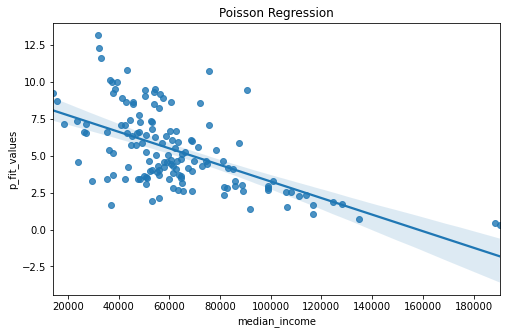

In [7]:
tract_pop_income['p_fit_values'] = burg_income_pois.fittedvalues
plt.rcParams["figure.figsize"] = [8, 5]
sns.regplot('median_income', 'p_fit_values',
                data = tract_pop_income).set(title="Poisson Regression")
poisson_test = sm.add_constant(tract_pop_income['median_income'])
tract_pop_income['p_predict'] = burg_income_pois.predict(poisson_test)

#### Creating Poisson testing model in preparation for negative binomial (following tutorial)

In [8]:
expr = """burglary_count ~ median_income"""

y_train, X_train = dmatrices(expr, tract_pop_income, return_type='dataframe')
y_test, X_test = dmatrices(expr, tract_pop_income, return_type='dataframe')

poisson_training_results = (sm.GLM(y_train, X_train, 
                                   family=sm.families.Poisson(),
                                   offset = tract_pop_income['log_population'])
                            .fit())                                    
display(poisson_training_results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burglary_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -483.16
Date:                Fri, 15 Oct 2021   Deviance:                       497.59
Time:                        10:21:53   Pearson chi2:                 1.02e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5612
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.6562      0.105    -53.986      0.000      -5.862      -5.451
median_income -1.821e-05    1.8e-06    -10.111      0.000   -2.17e-05   -1.47e-05
=================================================================================
"""

In [34]:
tract_pop_income['burglary_lambda'] = poisson_training_results.mu

tract_pop_income['AUX_OLS_DEP'] = (tract_pop_income.apply(
    lambda x: ((x['burglary_count'] - x['burglary_lambda'])**2 - x['burglary_lambda']) / 
              x['burglary_lambda'], 
               axis=1))

ols_expr = """AUX_OLS_DEP ~ burglary_lambda -1"""

aux_olsr_results = smf.ols(ols_expr, tract_pop_income).fit()

print(aux_olsr_results.params)

burglary_lambda    0.681586
dtype: float64


In [35]:
aux_olsr_results.tvalues

burglary_lambda    0.847271
dtype: float64

### Creating Negative Binomial Model

In [37]:
nb2_training_results = (sm.GLM(y_train, X_train,
                              family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0]),
                              offset = tract_pop_income['log_population'])
                        .fit())
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burglary_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -387.92
Date:                Fri, 15 Oct 2021   Deviance:                       100.58
Time:                        10:40:42   Pearson chi2:                     248.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1615
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.7588      0.211    -27.284      0.000      -6.172      -5.345
median_income -1.476e-05   3.26e-06     -4.525      0.000   -2.12e-05   -8.37e-06
=================================================================================
"""

C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


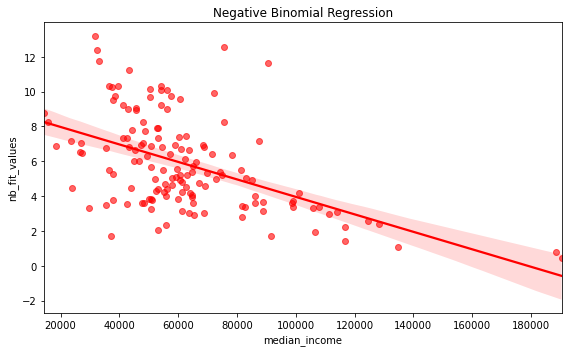

In [38]:
tract_pop_income['nb_fit_values'] = nb2_training_results.fittedvalues

plt.rcParams["figure.figsize"] = [8, 5]
sns.regplot('median_income', 'nb_fit_values',
            data = tract_pop_income, 
            color='red', 
            line_kws={'color':'red'},
            scatter_kws= {'alpha': 0.6, 'color': 'red'}).set(title="Negative Binomial Regression");

### Side by side graphs of Poisson & Negative Binomial with fitted values plotted against median income

C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Conrad\AppData\Local\Temp/ipykernel_32892/3217920378.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


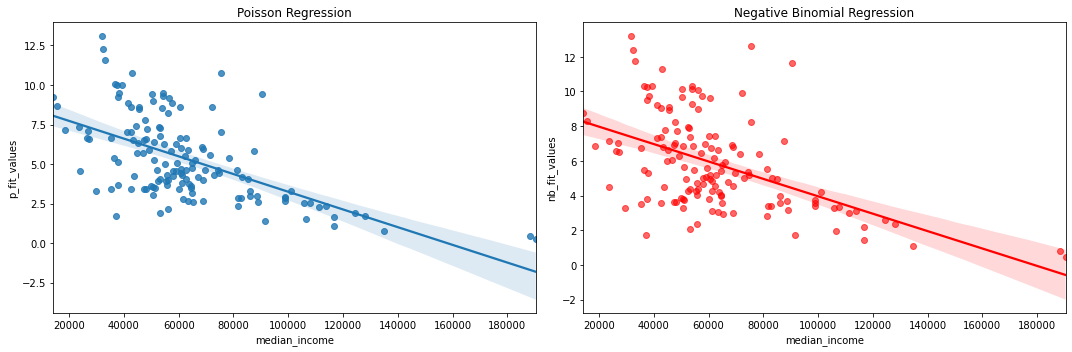

In [39]:

plt.rcParams["figure.figsize"] = [15.00, 5]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,2)

ax[0].set_title("Poisson Regression")
sns.regplot('median_income', 
            'p_fit_values',
            data = tract_pop_income, 
            ax=ax[0])

ax[1].set_title("Negative Binomial Regression")
sns.regplot('median_income', 
            'nb_fit_values',
            data = tract_pop_income, 
            ax=ax[1], 
            line_kws={'color':'red'},
            scatter_kws= {'alpha': 0.6, 'color': 'red'})
fig.show();

#### Overlay of the two graphs to show difference

C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='median_income', ylabel='nb_fit_values'>

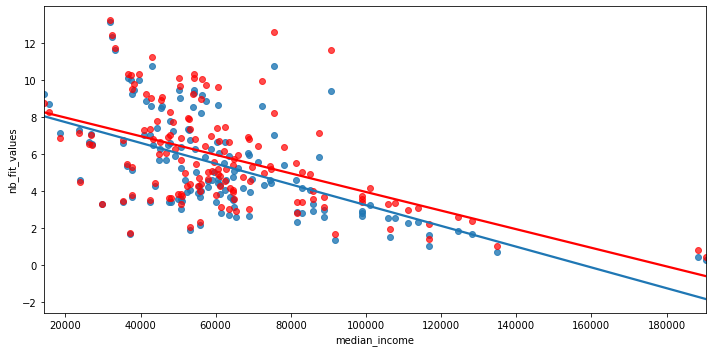

In [33]:
fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = [10, 5]
sns.regplot('median_income', 
            'p_fit_values',
            data = tract_pop_income, 
            ax=ax,
            ci=None)


sns.regplot('median_income', 
            'nb_fit_values',
            data = tract_pop_income, 
            ax=ax, 
            ci=None,
            line_kws={'color':'red'},
            scatter_kws= {'alpha': 0.7, 'color': 'red'})